# **Installation**

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# **Data Import**

In [2]:
# Create a DataFrame from CSV data
df = pd.read_csv("strokes.csv")

# **Feature Engineering**

In [3]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage', 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

#inches to yards
df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36


In [4]:
df['lie_location'] =    np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        #np.where(df['dist_to_hole_after_shot'] == 0, 'Hole',
                        #distance_to_hole_after_the_shot == 0 ~ 'Hole',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown'))))))))

# df = df[df['lie_location'] != 'Unknown']
df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

df['strokes_to_hole_out'] = df['hole_score'] - df['shot'] +1


# **Drop Holes with Penalties**

- Figure out how to use the 400 discarded rows in the future

In [5]:
df['flag_strokes_to_hole_out_1_or_less'] = df['strokes_to_hole_out'] <= 0

selected_rows = df[df['flag_strokes_to_hole_out_1_or_less']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Water or Unknown Lies**

In [6]:
result_df['flag_water_or_unknown_lies'] = (result_df['lie_location'] == 'Water') | (result_df['lie_location'] == 'Unknown')

selected_rows = result_df[result_df['flag_water_or_unknown_lies']]

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

# **Drop Holes with Non Standards Shot Types**

In [7]:
result_df['flag_non_standard_shot_types'] = result_df['shot_type'] != 'S'

selected_rows = result_df[result_df['flag_non_standard_shot_types']]

#-----

# Get the 'player_id' and 'round_hole_combination' for the selected rows
players_to_remove = selected_rows[['player_id', 'round_hole_combination']]

# Remove corresponding 'round_hole_combination' for each player
result_df = result_df.merge(players_to_remove, on=['player_id', 'round_hole_combination'], how='left', indicator=True)
result_df = result_df[result_df['_merge'] == 'left_only']

# Drop the indicator column and reset the index
result_df = result_df.drop(columns=['_merge']).reset_index(drop=True)

In [8]:
# Shift all values in the 'column_name' down by one row
result_df['lie_location'] = result_df['lie_location'].shift(1)

result_df['lie_location'] =    np.where(result_df['shot'] == 1, 'Tee',result_df['lie_location'])

#sanity check tee looks good
#result_df[['last_name', 'round_hole_combination','shot', 'hole_score','strokes_to_hole_out','distance_to_pin','lie_location','first_putt']].iloc[:10]

# sanity check making sure no chip ins

# idx = result_df.groupby('round_hole_combination')['shot'].idxmax()

# result_df[['distance_to_pin','lie_location','first_putt','to_location_laser','to_location_scorer']].loc[idx].iloc[:30]


# **Distance to Pin vs Strokes to Hole Out**

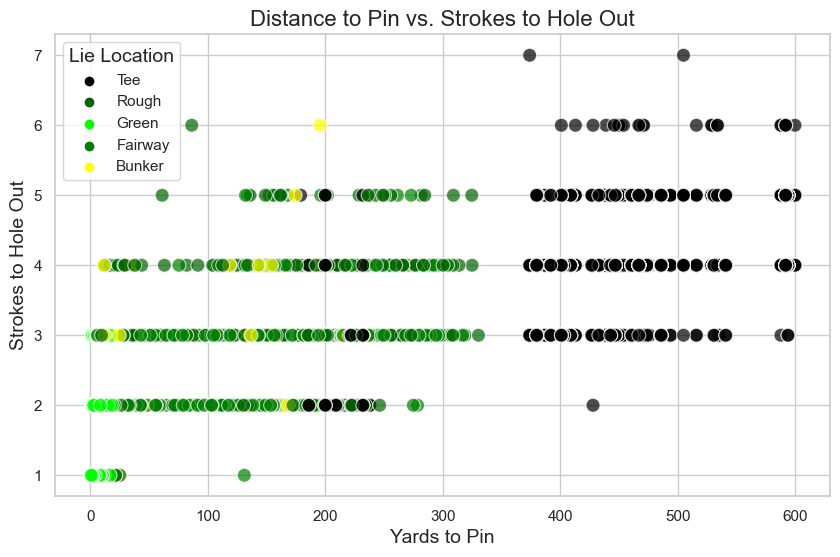

In [9]:
# Define a color palette
pal = {
    'Rough': '#006400',
    'Green': '#00FF00',
    'Hole': 'red',
    'Fairway': '#008000',
    'Bunker': 'yellow',
    'Tee': 'black'
}

# Set Seaborn style
sns.set(style='whitegrid')

# Create scatter plot with improved aesthetics
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='distance_to_pin', y='strokes_to_hole_out', hue='lie_location', palette=pal, data=result_df, s=100, alpha=0.7)

# Set plot title and labels
plt.title('Distance to Pin vs. Strokes to Hole Out', fontsize=16)
plt.xlabel('Yards to Pin', fontsize=14)
plt.ylabel('Strokes to Hole Out', fontsize=14)

# Customize legend
scatter_plot.legend(title='Lie Location', title_fontsize='14', loc='upper left')

# Show the plot
plt.show()
